In [2]:
import matplotlib.pyplot as plt

import numpy as np

import GPy

from athena.active import ActiveSubspaces
from athena.utils import Normalizer

import warnings
warnings.filterwarnings('ignore')

from scipy.interpolate import CubicSpline as spline
from scipy.io import loadmat
from scipy.interpolate import Akima1DInterpolator as akima
from scipy.integrate import quad
from scipy.optimize import root, minimize_scalar
from sklearn.utils import resample
from scipy.stats import uniform

import tikzplotlib as tpl

import pyTOP.fem2d as fe

import nlopt

import pickle

Setting up the heat diffusion problem with finite elements

In [3]:
# Generate mesh
nx = 16
ny = 16
mesh = fe.Mesh(nx, ny,-1,-1,2,2)
nelem = mesh.getNelems()
nddl = mesh.getNddlsScal()
refElem = fe.RefElement(mesh)

# Boundary conditions
dirichletnodes = np.sort(list(range(0,32))+list(range(1056,1088))+list(range(33,1023,33))+list(range(65,1055,33)))
dirichletddls = np.sort(mesh.getDDLnumerScal()[dirichletnodes].flatten())
ess = np.zeros_like(dirichletddls)

# Initialize diffusion problem
heat_solver = fe.Problem(mesh,1)
heat_solver.setDirichletBC(dirichletddls,ess)
mDivAGradT = fe.DiffusionTerm(refElem, mesh.getNelems())
heat_solver.addTerm(mDivAGradT)
f = lambda x : 56*(1-np.abs(x[0])-np.abs(x[1]))**6
heatsource = fe.SourceTermScal(refElem)
heatsource.setParams(f)
heat_solver.addTermRHS(heatsource)

# Physical Parameters
k1 = 2
k2 = 1
Emax = 1.35

Beginning mesh generation...
Mesh generated!


In [4]:
def displayDesignTri(sol):
    # dens = np.ones(nelem)
    # dens[free] = sol
    vertices = mesh.getElemNodes()[:,:3]
    coords = mesh.getNodeCoord()
    plt.figure(figsize=(8,8))
    for i in range(nelem):
        cv = coords[vertices[i,:]]
        plt.fill(cv[:,0],cv[:,1],facecolor=(((52-83)*sol[i]+83)/255,((201-138)*(sol[i])+138)/255, (((235-150)*sol[i])+150)/255),edgecolor="w",linewidth=1)
    plt.title("Bimaterial distribution (k1 = black, k2 = white)")
    tpl.save("eigenvector.tex")
    plt.show()

In [5]:
def displayDesignTriBW(sol):
    # dens = np.ones(nelem)
    # dens[free] = sol
    vertices = mesh.getElemNodes()[:,:3]
    coords = mesh.getNodeCoord()
    plt.figure(figsize=(8,8))
    for i in range(nelem):
        cv = coords[vertices[i,:]]
        plt.fill(cv[:,0],cv[:,1],facecolor=(1-sol[i],1-sol[i],1-sol[i]),edgecolor="r",linewidth=1)
    plt.title("Bimaterial distribution (k1 = black, k2 = white)")
    tpl.save("solutionAS.tex")
    plt.show()

Setting up function + gradient to be analyzed with the active subspace method

In [6]:
# Problem to compute matrix of gradient of basis functions
probleme_grad = fe.Problem(mesh,1)
gradugradu = fe.DiffusionTerm(refElem, mesh.getNelems())
csttensorfield = [np.eye(2) for k in range(nelem)]
gradugradu.setParams(csttensorfield)
probleme_grad.addTerm(gradugradu)
probleme_grad.solve(OnlyAssembly=True)
GradMatrix = probleme_grad.getCurrentElemMat()

# Declare Objective (volume) + Constraint (energy) and gradients
def V(x,normalizer=None):
    if normalizer is not None:
        x = normalizer.inverse_transform(x)
    return np.dot((0.5*(2/ny)**2)*np.ones(nelem),(x+1)/2)

def dV(x,normalizer=None):
    if normalizer is not None:
        x = normalizer.inverse_transform(x)
    return (0.25*(2/ny)**2)*np.ones(nelem)

def G(x,normalizer=None):
    if normalizer is not None:
        x = normalizer.inverse_transform(x)
    tensorfield = [((k1-k2)*(x[k]+1)/2 + k2)*np.eye(2) for k in range(nelem)]
    mDivAGradT.setParams(tensorfield)
    U=heat_solver.solve()
    j = 0.5*heat_solver.getCurrentMatrix().dot(U).dot(U)
    print(f"Thermal energy = {j}")
    return j - Emax

def dG(x,normalizer=None):
    if normalizer is not None:
        x = normalizer.inverse_transform(x)
    grad = np.zeros(nelem)
    tensorfield = [((k1-k2)*(x[k]+1)/2 + k2)*np.eye(2) for k in range(nelem)]
    mDivAGradT.setParams(tensorfield)
    U=heat_solver.solve()
    for k in range(nelem):
        grad[k] = (-1/4)*(k1-k2)*GradMatrix[:,nddl*k:nddl*(k+1)].dot(U).dot(U)
    return grad



Beginning assembly...
Assembly done!


In [7]:
np.random.seed(42)

# Global parameters
n_samples = nelem
input_dim = nelem

# Uniformly distributed inputs
lb = -1 * np.ones(input_dim)
ub = 1 * np.ones(input_dim)

def inputs_uniform(n_samples, n_pars, lb,  ub):
    return np.vstack(np.array([np.random.uniform(lb[i], ub[i], n_samples) for i in range(n_pars)]).T)

def profile(active, ss, f_out, N=1):
    return np.array([f_out(ss.inverse_transform(active)[0]) for i in range(N)])

# Generate and normalize inputs
X = inputs_uniform(n_samples, input_dim, lb, ub)
nor = Normalizer(lb, ub)

def sampler(x, normalizer=None):
    GG = np.zeros((x.shape[0],1))
    if normalizer is not None:
        x = normalizer.inverse_transform(x)
    for i in range(x.shape[0]):
        GG[i,0] = G(x[i,:].flatten(),normalizer)
    return GG

Compute df (this step is very long because the FEM code is not optimized). This can be skipped if dfData.npy is loaded afterwards.

In [ ]:
df = np.zeros((n_samples, input_dim))
for i in range(n_samples):
    df[i,:] = dG(X[i,:])
np.save("dfData",df)

Load precomputed df

In [8]:
df = np.load("dfData.npy")

Compute the active subspace and study eigenvalue decay

In [8]:
# Compute the active subspace
asub = ActiveSubspaces(dim=1)
asub.fit(gradients=df)
file = open("subspace.pickle","wb")
pickle.dump(asub,file)
file.close()


In [9]:
file = open("subspace.pickle","rb")
asub = pickle.load(file)
file.close()

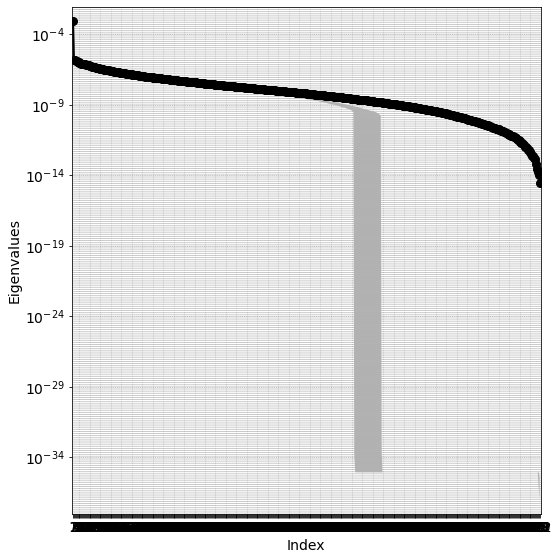

(0,0.000882448329127676)
(1,1.5953761821851023e-06)
(2,1.489499783719553e-06)
(3,1.383757980590466e-06)
(4,1.2411339490419155e-06)
(5,1.1333426582558588e-06)
(6,1.0449642267748638e-06)
(7,1.018367092349931e-06)
(8,8.842110106606098e-07)
(9,8.625994793559538e-07)


In [9]:
asub.plot_eigenvalues()
for i in range(10):
    print(f"({i},{asub.evals[i]})")

In [10]:
eigenvec = (asub.evects[:,0])
ymax = 1/np.max(np.abs(eigenvec))
ymin = -1/np.max(np.abs(eigenvec))
print(ymax)
print(ymin)

8.091233729349964
-8.091233729349964


First eigenvector

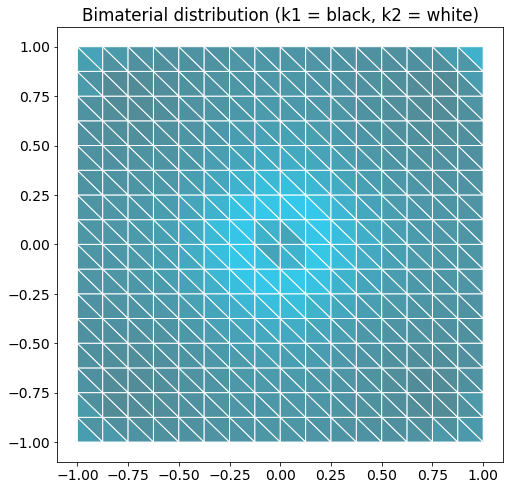

In [11]:
displayDesignTri(ymax*eigenvec)


Determine the profile along the active subspace. This can be skipped if the training data is loaded in the next cell.

In [ ]:
M_test = 50
X_test = inputs_uniform(M_test, input_dim, lb, ub)
x_reduced = asub.transform(X_test)[0]
#asub.inverse_transform(x_forward)
Gx = sampler(X_test)
np.save("fData",Gx)
np.save("Xtest",X_test)

In [12]:
M_test = 50
X_test = np.load("Xtest.npy")
Gx = np.load("fData.npy")
x_reduced = asub.transform(X_test)[0]

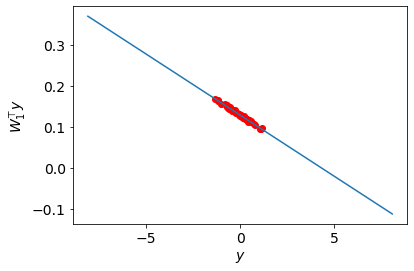

In [13]:
# Linear fit
coeff = np.polyfit(x_reduced.flatten(),Gx,1)
p = lambda x : np.polyval(coeff,x) 

plt.figure(figsize=(6, 4))
plt.scatter(x_reduced.flatten(), Gx, c='r', label='Optimal profile')
yy = np.linspace(ymin,ymax)
plt.plot(yy,p(yy))
plt.xlabel("$y$")
plt.ylabel("$W_1^\\top y$")
tpl.save("energyprofile.tex")
plt.show()

Determine the bias to reach a given conservativeness threshold. Here, we use a simple linear regression because of the shape of the data...

In [106]:
import casm

iota = 1e-6
pb, bias = casm.computeBiasedPolySurrogate(x_reduced,Gx,Gx.reshape((1,M_test)),1,0,10,iota/10,1-iota,20000,50,False)
coeffb = np.polyfit(x_reduced.flatten(),Gx+bias,1)

Iteration 0 : fit done
Iteration 0 : bootstrap estimator done (Eboot[S] = 5.000001752273854, Vboot[S] = 3.640441944997004e-06)
Iteration 0 : concentration bound done
Iteration 0 : bias = 5.0, success probability = 1.0
Iteration 1 : fit done
Iteration 1 : bootstrap estimator done (Eboot[S] = 2.500003165664259, Vboot[S] = 3.6404343214581984e-06)
Iteration 1 : concentration bound done
Iteration 1 : bias = 2.5, success probability = 1.0
Iteration 2 : fit done
Iteration 2 : bootstrap estimator done (Eboot[S] = 1.249998853226315, Vboot[S] = 3.644388338580975e-06)
Iteration 2 : concentration bound done
Iteration 2 : bias = 1.25, success probability = 1.0
Iteration 3 : fit done
Iteration 3 : bootstrap estimator done (Eboot[S] = 0.624997221095996, Vboot[S] = 3.6395864044502112e-06)
Iteration 3 : concentration bound done
Iteration 3 : bias = 0.625, success probability = 1.0
Iteration 4 : fit done
Iteration 4 : bootstrap estimator done (Eboot[S] = 0.31250051066087464, Vboot[S] = 3.639634480165382

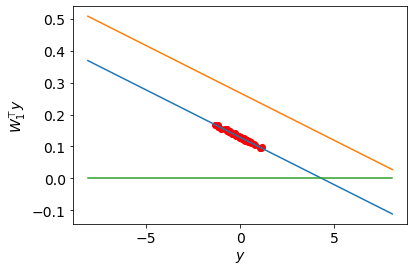

In [107]:
plt.figure(figsize=(6, 4))
plt.scatter(x_reduced.flatten(), Gx, c='r', label='Optimal profile')
yy = np.linspace(ymin,ymax)
plt.plot(yy,p(yy))
plt.plot(yy,pb(yy))
plt.plot(yy,np.zeros_like(yy))
plt.xlabel("$y$")
plt.ylabel("$W_1^\\top y$")
plt.show()

Optimization problem with the low-dimensional constraint

In [108]:
def Obj(x,grad):
    grad[:] = dV(x)
    print(f"Volume = {V(x)}")
    return V(x)

# biased surrogate
def Consb(x,grad):
    y = asub.transform(x)[0]
    grad[:] = coeffb[0][0].flatten()*eigenvec.flatten()
    print(f"Constraint = {pb(y)[0]}")
    return pb(y)[0]

# unbiased surrogate
def Cons(x,grad):
    y = asub.transform(x)[0]
    grad[:] = coeff[0][0].flatten()*eigenvec.flatten()
    print(f"Constraint = {p(y)[0]}")
    return p(y)[0]


optim_solver = nlopt.opt(nlopt.LD_MMA, nelem)
optim_solver.set_min_objective(Obj)
optim_solver.set_lower_bounds(-1.0*np.ones(nelem))
optim_solver.set_upper_bounds(1.0*np.ones(nelem))
optim_solver.add_inequality_constraint(Consb)
optim_solver.set_param("verbosity",2)
#solver.set_stopval(1e25)
optim_solver.set_maxeval(500)
optim_solver.set_xtol_abs(1e-10)

sol = optim_solver.optimize(1.0*np.ones(nelem))
result = optim_solver.last_optimize_result(); # 1 = success, 2 = values over the max value, 4 = xtol conv
print(f"Exit code = {result}")
print(f"Neval J = {optim_solver.get_numevals()}")

Volume = 4.0
Constraint = -0.2427608338134386
Volume = 3.992247945553594
Constraint = -0.2407811560790053
Volume = 3.9196888000899985
Constraint = -0.22225139397571086
Volume = 3.4673314735776324
Constraint = -0.11785372703205876
Volume = 2.8647710877320556
Constraint = -0.047682663213747256
Volume = 2.3784350268954064
Constraint = -0.021625120973086387
Volume = 2.1163450097622776
Constraint = -0.008316513572866557
Volume = 1.9980199238506768
Constraint = -0.0038333250276219033
Volume = 1.9424213664470351
Constraint = -0.0016786735594137014
Volume = 1.9150999321886766
Constraint = -0.0009559483480446884
Volume = 1.898755983601334
Constraint = -0.0006173395894868983
Volume = 1.8878345746430236
Constraint = -0.00040979653047235054
Volume = 1.8807866365308024
Constraint = -0.0002743570801180817
Volume = 1.8759817847129088
Constraint = -0.00018485355078645682
Volume = 1.8731524657830785
Constraint = -9.249678243200554e-05
Volume = 1.8715160644717908
Constraint = -6.25396147542201e-05
Volum

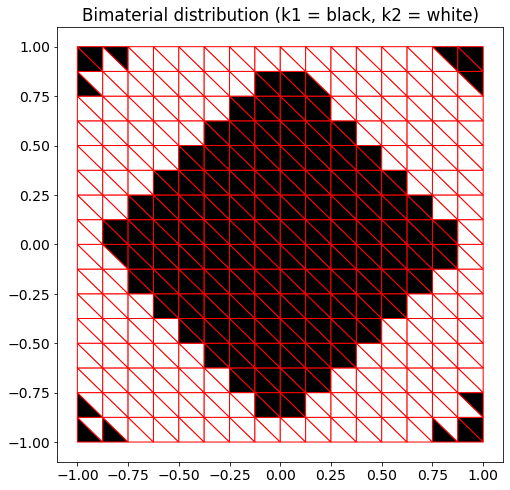

In [109]:
displayDesignTriBW((sol+1)/2)

Compute exact constraint violation

In [110]:
100*G(sol)/Emax

Beginning assembly...
Assembly done!
Beginning solving...
Solved!
Thermal energy = 1.3276118681519162


-1.6583801368951006